# Project

## Introduction to the Project
The S&P 500 (Standard & Poor's 500) is a stock market index that tracks the performance of 500 of the largest publicly traded companies in the United States. It is widely regarded as one of the best representations of the U.S. stock market and economy. Over the long term, the S&P 500 has shown consistent growth, making it a key focus for long-term investors. However, it can also experience significant volatility in the short term.

In this project, we will make our first attempt to build a momentum-based strategy to trade the S&P 500 index. At the end of the project, you will have built a program that you can later expand and customise to suit your needs. We will use the python packages numpy, scipy and sqlite3, among others, in this project.

Tips: Review the code snippets that we went through during the course. Reorganize them and you are half-way done! Try experimenting with different configurations of the confidence interval, the lookback window and the forecast horizon. Be brave and experiment with different ways of deciding the position size. You may be surprised by your talent!

Re-organize your code from the exercises into a Python program that 
1. read prices from a database
2. calibrate a GBM model on each day when new prices are received.
3. forecast the price in e.g. 10 days and
   1. calculate the confidence interval of the forecast
   2. calculate the expected shortfall from the price forecast
4. code your trading signals using the price forecast and the expected shortfall.
5. store your postions into the *positions* table after each trade.
6. produce a 1-year backtest record from 2020-06-01 to 2021-05-31.

**Hint**

1. Collect all the code related to the GBM model into a class

In [3]:
import numpy as np
import csv
import sqlite3
from scipy.stats import norm
from contextlib import closing

conn = None
cs = None


In [4]:
class GBM:
    def __init__(self):
        # TODO: Replace the following with your code
        self.mu, self.sigma = [np.nan] * 2
        
    def simulate(self, N, K, Dt, S0):
        traj = np.full((N+1, K), np.nan)
        # TODO: Your code goes here
        return traj

    def calibrate(self, trajectory, Dt):
        # TODO: Your code goes here
        pass
        
    def forecast(self, latest, T, confidence):
        # TODO: Your code goes here
        pass
        
    def expected_shortfall(self, T, confidence):
        # TODO: Your code goes here
        pass


In [ ]:
# test your code here
model = GBM()
model.mu = 0.3
model.sigma = 0.2
simulated = np.flatten(model.simulate(500, 1, 1/250, 100))

model2 = GBM()
model2.calibrate(simulated, 1/250)

print(F"Calibrated: mu = {model2.mu}, sigma = {model2.sigma}")



2. Write a function that prepares the database for trading, i.e.
   1. load the historical prices into the *prices* table
   2. create the *positions* table
   3. initialize the *positions* table with the your initial cash reserve. The initial *time_of_trade* can be any date before the earliest possible trading date.

    Call this function *prepare*.

In [1]:
def prepare():
    # TODO: Your code goes here

In [6]:
# check whether you have loaded the prices correctly
conn = sqlite3.connect("SP500.db")
cs = conn.cursor()
latest_prices = cs.execute("select * from prices order by theday desc limit 10")
for item in latest_prices:
    print(item)
cs.close()
conn.close()



('2021-05-31', 4203.60009765625)
('2021-05-30', 4210.10009765625)
('2021-05-28', 4206.0)
('2021-05-27', 4217.10009765625)
('2021-05-26', 4196.0)
('2021-05-25', 4197.5)
('2021-05-24', 4204.7001953125)
('2021-05-23', 4153.2998046875)
('2021-05-21', 4161.39990234375)
('2021-05-20', 4165.5)


3. Write a function that determines the trade size, i.e. how many units of the instrument you would like to own when the date is *which_day* and the price forecast of the instrument is *forecast* and the expected shortfall from the same forecast is *ES*.

In [4]:
def position_size(which_day, forecast, ES):
    # TODO: Your code goes here

4. Write a function that, for a given date, calibrates a GBM model to the data prior to that date and that forecasts the price in 10 days. Call this function *analyse*.

In [5]:
def analyse(which_day):
    # TODO: Your code goes here    


In [ ]:
# Test the analyse function
test_dates = ['2021-05-09', '2021-05-14']
positions = [np.nan, np.nan]
for i in range(2):
    positions[i] = analyse(test_dates[i])
    print(F"{positions[i]} shares advised on {test_dates[i]}.")


5. The main loop of the program: Loop over the dates in the backtest period and use the *analyse* function to decide what to do on each day. Call this function *main*.

In [6]:
def main(begin_on):
    cs.execute(F"select theday from prices where theday >= '{begin_on}';")
    days = [d[0] for d in cs.fetchall()]
    asset = {
        'old': np.nan,
        'new': np.nan
    };
    cash = {
        'old': np.nan,
        'new': np.nan
    };
    cs.execute("delete from positions where time_of_trade > '2020-01-01';");
    for d in days:
        asset['new'] = analyse(d)
        cs.execute(F"""
        select quantity, cash from positions
        where time_of_trade < '{d}'
        order by time_of_trade desc
        limit 1;
        """);
        asset['old'], cash['old'] = cs.fetchall()[0];
        cs.execute(F"""
        select price from prices
        where theday <= '{d}'
        order by theday desc
        limit 1;
        """);
        latest = cs.fetchall()[0][0]
        trade_size = round(asset['new']) - round(asset['old']);
        if trade_size != 0:
            cash['new'] = cash['old'] - trade_size * latest;
            cs.execute(F"""
            insert into positions values
            ('{d}', 'SP500', {round(asset['new'])}, {cash['new']});
            """);
        conn.commit();



6. Connect to the database and create a *cursor* object associated with the connection. Share the connection and the cursor object across the program so that you don't have to connect to and disconnect from the database in every function of the program.

In [ ]:
if __name__ == "__main__":
    with closing(sqlite3.connect("SP500.db")) as conn:
        with closing(conn.cursor()) as cs:
            prepare()
            main('2020-06-01')
    


In [51]:
# plot your track record
conn = sqlite3.connect("SP500.db")
cs = conn.cursor()
day1 = '2020-06-01'

cs.execute(F"""
    select (unixepoch(theday) - unixepoch('{day1}'))/(3600.0 * 24) as T,
    quantity * price + cash as wealth
    from positions as PO
    join prices as PR
    on PO.time_of_trade = (
        select time_of_trade from positions
        where time_of_trade <= PR.theday
        order by time_of_trade desc limit 1
    )
    where theday >= '{day1}'
""")
records = cs.fetchall()

In [13]:
import matplotlib.pyplot as plt

In [52]:
W = np.asarray(records)

Text(0, 0.5, 'Total Wealth')

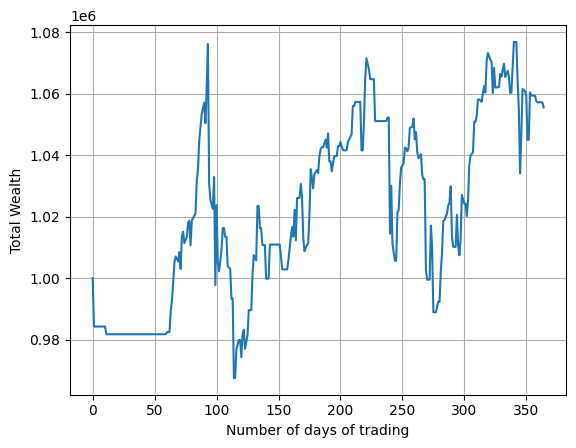

In [56]:
fig = plt.plot(W[:,0], W[:, 1])
plt.grid()
plt.xlabel("Number of days of trading")
plt.ylabel('Total Wealth')